## OpenNeuro reuse analysis

This notebook reports results from analyses of reuse of OpenNeuro datasets.  Data were initial generated by Joe Wexler, and then cleaned up an analyzed by Russ Poldrack.

Here is the detailed description of the process that Joe used to obtain the statistics:

> First, I used PyPaperBot to search google scholar for "openneuro" and attempt to download a pdf of each result from sci-hub as well as their metadata via the crossref api. Next, I performed various checks to validate the pdf files and metadata and determined which needed to be acquired manually. I then acquired some of these manually, as well as some of the remaining metadata with pybliometrics, which uses the scopus api. Next, I converted the pdf files to txt files using pdf2txt and searched each for dataset accession numbers. I manually looked at each mention of an accession number to determine whether it was should be considered a reuse, which was defined as the authors actually using OpenNeuro to acquire the dataset mentioned in the paper. This wasn't always possible to determine for certain so I just used my best judgement. The most common disqualifier was one or more shared authors between the dataset and the paper. Finally, I noticed that the 'num_citations' field from scopus was much lower in some cases than the count on google scholar. I guessed that google scholar counts were more accurate so I reaquired this field for each paper using scholarly, which scrapes directly from google scholar. (Btw, in case it's relevant, most of the manual entry I did was using user-input scripts to speed up the process.)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from crossref.restful import Works
import collections
import seaborn as sns
from time import sleep
import matplotlib.pyplot as plt 
import pickle
import os

datadir = Path('../data')

### Load data

Data were dumped to csv from https://docs.google.com/spreadsheets/d/1F0AuD4-gYboM3KHac8MNMW4WYCMcSDexy0BIYrbXJ6g/edit?usp=sharing

In [2]:
# publications
papers = pd.read_csv(datadir / 'reuse/reuse_papers.csv').rename({'Number of Citations': 'n_citations'}, axis=1)
print(f'Found {papers.shape[0]} papers')

# dataset reuses
mappings = pd.read_csv(datadir / 'reuse/reuse_mappings.csv')
print(f'Found {mappings.shape[0]} reuses')


Found 165 papers
Found 281 reuses


OpenNeuro metadata dumped from metadata.openneuro.org


In [3]:
# load metadata and get total number of subjects to estimate costs
mapper = {'Assession Number': 'AccessionNumber', '# of subjects': 'nsubjects'}
metadata = pd.read_csv(datadir / 'openneuro/metadata_06182021.csv', skiprows=1).rename(mapper, axis=1)


Use crossref and arxiv APIs to obtain detailed information about each publication

In [4]:
works = Works()
doi_file = '../data/openneuro/doi_data.pkl'

# try to reuse existing if possible
try:
    doi_data
except NameError:
    if os.path.exists(doi_file):
        with open(doi_file, 'rb') as f:
            doi_data = pickle.load(f)
    else:
        doi_data = {}

for i, doi in enumerate(papers.DOI):
    if doi is np.nan:
        continue
    if i in doi_data:
        continue
    if doi.find('arxiv') > -1:
        s = arxiv.Search(doi.replace('arxiv:', ''))
        results = [i for i in s.get()]
        doi_data[i] = {'title': results[0].title}
    else:
        try:
            doi_data[i] = works.doi(doi)
            sleep(np.random.rand() * 0.5) # insert random delay to keep API from getting unhappy
        except:
            # sometimes it randomly fails, retry
            doi_data[i] = works.doi(doi)

with open(doi_file, 'wb') as f:
    pickle.dump(doi_data, f)

Obtain journal names from crossref outputs when possible, and classify publications in terms of publication type.

In [5]:
# add journal name to main sheet

archives = ['biorxiv', 'arxiv', 'psyarxiv', 'medrxiv']
papers['journal'] = None
papers['pubtype'] = None

for i, doi in enumerate(papers.DOI):
    journal = None
    if papers.loc[i, 'Publisher'] in archives:
        journal = papers.loc[i, 'Publisher']
        papers.loc[i, 'pubtype'] = 'preprint'
    elif papers.loc[i, 'Publisher'] in ['thesis', 'blog']:
        journal = None
        papers.loc[i, 'pubtype'] = 'other'
    elif (i in doi_data) and (doi_data[i] is not None) and (
        'container-title' in doi_data[i]) and (len(doi_data[i]['container-title']) > 0):
            journal = doi_data[i]['container-title'][0]
            papers.loc[i, 'pubtype'] = 'journal'
        #print(i, journal)
    papers.loc[i, 'journal'] = journal

Identify mappings between DOIs and datasets

In [6]:
# add datasets into papers data frame
doi_datasets = collections.defaultdict(lambda: [])

# first find matches
for i in mappings.index:
    title = mappings.loc[i, 'Title']
    match = papers.query(f'Title == "{title}"')
    if match.shape[0] == 0:
        print('no match:', title)
    else:
        doi_datasets[match['DOI'].values[0]].append(mappings.loc[i, 'Dataset Mention'])

Compute number of datasets per paper and add to main data frame

In [7]:
papers['n_datasets'] = None
for i in papers.index:
    doi = papers.loc[i, 'DOI']
    if doi is not None:
        papers.loc[i, 'n_datasets'] = len(doi_datasets[doi])
        
papers['Year_int'] = papers['Year']
papers['Year'] = [str(i) for i in papers.Year]

Use openneuro metadata to get the number of subjects reused by each study

In [8]:

doi_numsubs = collections.defaultdict(lambda: 0)
for k, data in doi_datasets.items():
    for ds in data:
        dsmatch = metadata.query(f'AccessionNumber == "{ds}"')
        if dsmatch.shape[0] == 0:
            print(ds, 'no match')
        else:
            doi_numsubs[k] += dsmatch.nsubjects.sum()

ds002245 no match
ds001544 no match
ds000177 no match


### Reuse statistics

Distribution of different publication types:

In [20]:
papers.shape

(165, 12)

In [24]:
papers.pubtype = papers.pubtype.replace({None: 'other'})

In [27]:
papers.pubtype.value_counts()

journal     112
preprint     42
other        11
Name: pubtype, dtype: int64

Distribution over years

In [10]:
papers.Year.value_counts()

2020    74
2021    59
2019    24
2018     8
Name: Year, dtype: int64

<Figure size 432x360 with 0 Axes>

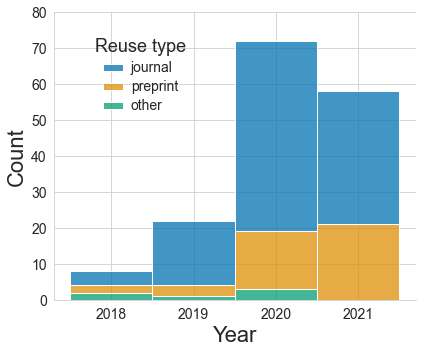

In [11]:

sns.set_style('whitegrid')
plt.figure(figsize=(6,5))
# plot reuses by year as split bar by type
papers = papers.sort_values('Year')

splot = sns.displot(x='Year', hue='pubtype', data=papers, 
            multiple="stack", palette='colorblind')

splot.legend.set_title('Reuse type')
plt.setp(splot.legend.get_texts(), fontsize='14') # for legend text
plt.setp(splot.legend.get_title(), fontsize='18') # for legend text
plt.xlabel('Year', fontsize=22)
_ = plt.ylabel('Count', fontsize=22)
splot.set_yticklabels([int(i) for i in splot.ax.get_yticks()], size = 14)
splot.set_xticklabels(splot.ax.get_xticklabels(), size = 14)
splot.legend._loc = 2
splot.legend.set_bbox_to_anchor([0.2, -.1, 1, 1])
plt.tight_layout()
plt.savefig('../figures/reuse_by_year.png')

In [12]:
splot.legend._loc

2

Distribution of # of reuses by dataset

ds000030    28
ds000224    18
ds000117    14
ds000228    12
ds000105     8
            ..
ds001894     1
ds001928     1
ds000206     1
ds002179     1
ds000237     1
Name: Dataset Mention, Length: 111, dtype: int64
(111,)


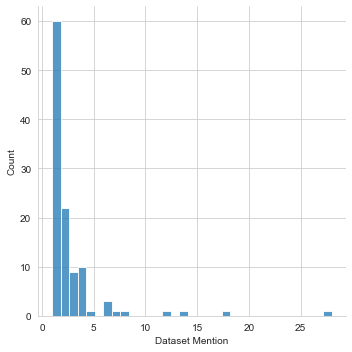

In [13]:
ds_counts = mappings['Dataset Mention'].value_counts()
print(ds_counts)
sns.displot(ds_counts)
print(ds_counts.shape)

Number of datasets with more than one reuse

In [14]:
sum(ds_counts>2)

29

Distribution of number of reuses across papers

fMRIPrep: a robust preprocessing pipeline for functional MRI                                                                                  40
Fine-grain atlases of functional modes for fMRI analysis                                                                                      27
Nature abhors a paywall: How open science can realize the potential of naturalistic stimuli                                                   10
Inter-group Heterogeneity of Regional Homogeneity (REHO)                                                                                       6
Side information dependence as a regularizer for analyzing human brain conditions across cognitive experiments                                 4
Automatic skull stripping of rat and mouse brain MRI data using U-net                                                                          3
Exploring the impact of analysis software on task fMRI results                                                                    

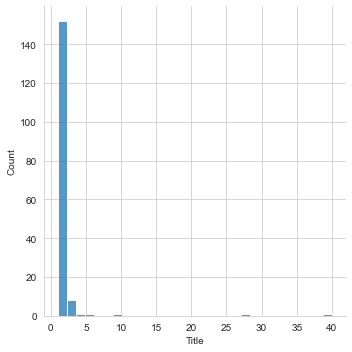

In [15]:
# of datasets per paper title
ndatasets_per_paper = mappings.Title.value_counts()
sns.displot(ndatasets_per_paper, bins=30)
ndatasets_per_paper[ndatasets_per_paper > 1]

Number of papers reusing more than 1 dataset


In [16]:

sum(mappings.Title.value_counts() > 1)

31

Compute total # of subjects and estimated total scan cost

In [17]:
total_nsubs = np.sum(list(doi_numsubs.values()))
print('total N:', total_nsubs)

cost_per_scan = 1000
print('total scan cost:', total_nsubs*cost_per_scan)


total N: 21121
total scan cost: 21121000


### Analysis of citations

Find most cited reuses

total of 1329 citations


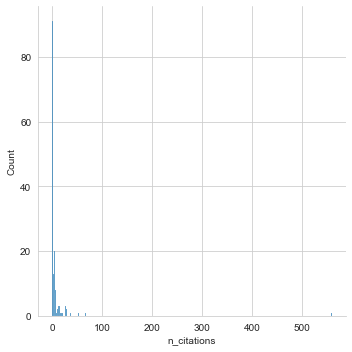

In [18]:
sns.displot(papers.n_citations)
print(f'total of {papers.n_citations.sum()} citations')

In [19]:
pd.set_option('display.max_rows', 40)
sorted_df = papers.sort_values('n_citations', ascending=False)
sorted_df.Title.values[:10]

array(['fMRIPrep: a robust preprocessing pipeline for functional MRI',
       'Exploring the impact of analysis software on task fMRI results',
       'There is no single functional atlas even for a single individual: Functional parcel definitions change with task',
       'MEG/EEG group analysis with brainstorm',
       'Fastsurfer-a fast and accurate deep learning based neuroimaging pipeline',
       'Functional connectivity predicts changes in attention observed across minutes, days, and months',
       'Identifying and removing widespread signal deflections from fMRI data: Rethinking the global signal regression problem',
       'Edge-centric functional network representations of human cerebral cortex reveal overlapping system-level architecture',
       'Probabilistic TFCE: a generalized combination of cluster size and voxel intensity to increase statistical power',
       'Estimating feedforward and feedback effective connections from fMRI time series: Assessments of statistical 